In [1]:
!pip -q install -U transformers sentence-transformers

In [2]:
import numpy as np
from pathlib import Path
from sklearn.linear_model import Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import numpy as np
import sklearn.linear_model
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import os
from sklearn.linear_model import RidgeCV
from scipy.spatial.distance import cdist

In [3]:
miniLM = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
sent_emb = miniLM.encode(["My first sentence.", "Another one."]) # (2, 384) numpy array

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [4]:
from transformers import BertTokenizer, BertModel
import torch, numpy as np

tok_bert = BertTokenizer.from_pretrained("bert-base-uncased")
bert      = BertModel.from_pretrained("bert-base-uncased")

def embed_with_bert(sentences, device="cpu"):
    bert.to(device).eval()
    with torch.no_grad():
        inputs  = tok_bert(sentences, return_tensors="pt",
                           padding=True, truncation=True).to(device)
        outputs = bert(**inputs).last_hidden_state # (batch, seq_len, 768)
        # simple pooling = mean over tokens
        sent_emb = outputs.mean(dim=1).cpu().numpy() # (batch, 768)
    return sent_emb

sent_emb = embed_with_bert(["hello world", "another sentence"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [5]:
import torch, numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

In [6]:
# Download and extract the data and learn_decoder.py
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56" -O files.zip && rm -rf /tmp/cookies.txt
!wget --header="Host: drive.usercontent.google.com" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7" --header="Accept-Language: en-US,en;q=0.9,he;q=0.8" --header="Cookie: HSID=AHJfxja1o67aaDDKP; SSID=AcFaYUEeiC88MwrF9; APISID=-FXvHmBvJ828Jrpq/AaIp_RI6gKwBAA-zy; SAPISID=_psqReiv0O2WdiVv/AhLpZThJtVNAPgAJP; __Secure-1PAPISID=_psqReiv0O2WdiVv/AhLpZThJtVNAPgAJP; __Secure-3PAPISID=_psqReiv0O2WdiVv/AhLpZThJtVNAPgAJP; S=billing-ui-v3=pX9aAWC8SzxQZfQvQ-0SbCFRz65PPkVY:billing-ui-v3-efe=pX9aAWC8SzxQZfQvQ-0SbCFRz65PPkVY:maestro=dsv3G-owxPD6uTATLH0lBQZNadhFo6ZKJiuB9usoQVU; __Secure-BUCKET=CPgG; SID=g.a000kggtmVDh8D92rqHe5fiG-bMoXQw7Ld8Tf_C8qHhSE2ZoFUyx_uObP_F4bCqI8I561ccGMwACgYKAWESARQSFQHGX2Mi5DnhBiJ2gjjbMSP0XJbU5BoVAUF8yKrlBjWMdNOfGnmA7TZzmbWD0076; __Secure-1PSID=g.a000kggtmVDh8D92rqHe5fiG-bMoXQw7Ld8Tf_C8qHhSE2ZoFUyx2BFINS8lXhFUyAFwuvl8CQACgYKAW4SARQSFQHGX2MiWd6bHkI0JN89-1dFZUbS2hoVAUF8yKpc-H3AD8N6tj-dmFG21SeE0076; __Secure-3PSID=g.a000kggtmVDh8D92rqHe5fiG-bMoXQw7Ld8Tf_C8qHhSE2ZoFUyxJl_TGsCsjeiVN72q3lSCWQACgYKASASARQSFQHGX2MiULluXa7aABDwxgCWjB6IyhoVAUF8yKoy_HHYLCqIFMwNjx-GwYWe0076; __Secure-ENID=20.SE=jyM_w2hA8DW6FvPOh9wudde93a0A9P41Epzo098LV_LyU79-VVcJ9K-vNLrhCLuVzi69CyV4RxlSls8AAT9J8odwIXi_ISVn8Z1U1DH52BC3YiwOwO9LKUsBesCbGx2D6u1XwZ5GIP_PZMo1tkLLJq2VCtcxRP9OtC_QgHNbAD4eyc1TTu1C8XbZLFTOIgb0k9IfM2bMBXeha6t3sJysARZWpDIzs3I8wWZ5JtABB253grtjQyCnxyy9MUgTcYAVaoEGwgVHV4V4lSY6gydFkO2gYxl7JqYloqCq74HahGK54TBlsGZIOTM_KvFAsIidcrPaVOBpH6IGQTPChxy3Tr-GLK7VpBiQ8JW7V0xC8XTN1crEaaZnGFQ6MrjDv8f3hCY0Kg; AEC=AQTF6HwEtUB747fVHMzvOWJV9pmRoGs8Ix8FJ1HTrxbE9NY1dtyro2AvNQ; NID=515=Wdt0NWZqVSh3TtdIfjXCGTCCkj7jaJjt-lkOL3hLD_hPSSMyGxKkVthECwGGFbbxmvfM2iKZ1SkPGDVgLwjghAOrV9Ya7iEJJ0eSXZSfszc0WxRXm3Jy6LxqPEZLmY8v3AIkMX-o8KE5ZRXGEzgv_s9pfgS8bmeiIGT13Iiyw9tPzRZDChGijNbZ0Mp1oF-4YKikOZCyo8Km9wXOgLAC9dbeIqAlTdER97cQ7B5GajyRLH_bFrg0lCVN4tyZEycjihHOu6Eq_V88rswgV7uvzemJ_yk4WbbIWJVm9NCO4tWdDQG8NY3EY57xAJbmIhu260jDftYwzjCnpqJ8C1iCm-FjboF6xJwKJEtLkCXagIcSWxfPGqRWIn5KY72ogAMZTlUZ5RE5F8bH4sFgkt5pW_AalY5mxYPOfZgF-9hcJYsF71rMOic6mqSfvR8iNo-k6_SZ-4o5WkYxbwdLgiaIOiCJHkhIGBoXsm5hh5BHDqlk5ERGnFn5zpqOguNLJFjXT3nhaP1g_a2fFvd0bmZw2A9Y6tBNAC7CbDOmSHSmYmLag0qVcqu286CZh5svuhdM-QPcSCt5u0kPgfWN3KBha0G9L9qCiDIwntvnlVNoUYLBM4je1bhGjO9M2tdH_vteLo4vjm9Cq-4I2A; __Secure-1PSIDTS=sidts-CjIB3EgAEi6AJoaJlu_IOdqmparuSFUne3RqD5YKK5hcqKjRlc0CTp9lSpyH2OoVVoqmlxAA; __Secure-3PSIDTS=sidts-CjIB3EgAEi6AJoaJlu_IOdqmparuSFUne3RqD5YKK5hcqKjRlc0CTp9lSpyH2OoVVoqmlxAA; SIDCC=AKEyXzW7IJ8miV8hX_pqzqqPW7--eMWuWfausspLBoDPlfZDCRZDED56ohpancLYOBPizfUzi1aM; __Secure-1PSIDCC=AKEyXzVGnmSuG07J22njRVFPQ_sk88MgnqtYxJd-M0_9Pz3jdh4GpGPhPOqCMrayTU9SJTW3n54; __Secure-3PSIDCC=AKEyXzVScJYbKdtIImPYKpTRkExsc5UhC5n9Rkk8wNFlMZNW3_xkvWlimAXWaZ4T7kTcJy5AE4I" --header="Connection: keep-alive" "https://drive.usercontent.google.com/download?id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56&export=download&authuser=0&confirm=t&uuid=efeb9ce5-a5c5-453b-938d-6c0ece963f3c&at=APZUnTV18b5mSao0MQ2JbtpefTxr%3A1719665236172" -c -O 'files.zip'
!unzip files.zip
!rm files.zip

--2025-08-20 08:35:28--  https://drive.usercontent.google.com/download?id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56&export=download&authuser=0&confirm=t&uuid=efeb9ce5-a5c5-453b-938d-6c0ece963f3c&at=APZUnTV18b5mSao0MQ2JbtpefTxr%3A1719665236172
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.64.132, 2607:f8b0:4001:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.64.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97708666 (93M) [application/octet-stream]
Saving to: ‘files.zip’

files.zip           100%[===================>]  93.18M  70.8MB/s    in 1.3s    

2025-08-20 08:35:29 (70.8 MB/s) - ‘files.zip’ saved [97708666/97708666]

Archive:  files.zip
  inflating: stimuli_180concepts.txt  
  inflating: learn_decoder.py        
  inflating: vectors_180concepts.GV42B300.txt  
  inflating: imaging_data.csv        


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os

folder_path = "/content/drive/MyDrive/Project Resources - Lang&Cog/Project 2: Word Embeddings and the Brain/Structured Task (sentence decoding)"
print(os.listdir(folder_path))

['stimuli_243sentences.txt', 'stimuli_384sentences.txt', 'vectors_243sentences.GV42B300.average.txt', 'vectors_384sentences.GV42B300.average.txt', 'EXP3.pkl', 'EXP2.pkl', 'neuralData_for_EXP1.csv']


In [9]:
# decoder given in PSET 3, for GloVe vectors
from learn_decoder import *

# and the data
fmri_data =  pd.read_csv(os.path.join(folder_path, "neuralData_for_EXP1.csv")).to_numpy()
vectors_glove_243 = np.loadtxt(os.path.join(folder_path, "vectors_243sentences.GV42B300.average.txt"))

with open(os.path.join(folder_path, "EXP3.pkl"), "rb") as f:
    exp3 = pickle.load(f)
data_243 = exp3["Fmridata"]  # shape (243, 185866)

In [10]:
sentences_243 = np.loadtxt(os.path.join(folder_path, "stimuli_243sentences.txt"), dtype=str, delimiter='.')

In [11]:
from scipy.spatial.distance import cdist
import numpy as np
from collections import defaultdict
from sklearn.linear_model import Ridge

# Cosine Rank Evaluation
def compute_average_rank(decoded, gold):
    distances = cdist(decoded, gold, metric='cosine')
    ranks = []
    for i in range(distances.shape[0]):
        gold_distance = distances[i, i]
        rank = np.sum(distances[i] < gold_distance)
        ranks.append(rank + 1)
    avg_rank = np.mean(ranks)
    return ranks, avg_rank

# Analysis 3 Loader (using known topic lengths)
def get_topic_blocks_analysis3(filename):
    topic_lengths = [11,10,10,10,10,10,10,10,10,10,10,10,10,9,11,10,11,10,10,10,10,10,11,10]

    with open(filename, "r") as f:
        sentences = [line.strip() for line in f if line.strip()]

    assert len(sentences) == 243, f"Expected 243 sentences, got {len(sentences)}"
    assert sum(topic_lengths) == 243, "Topic lengths don't sum to 243!"

    topic_ids = []
    for tid, length in enumerate(topic_lengths):
        topic_ids.extend([tid] * length)

    from collections import defaultdict
    topic_to_indices = defaultdict(list)
    for i, tid in enumerate(topic_ids):
        topic_to_indices[tid].append(i)

    topic_blocks = list(topic_to_indices.values())
    return sentences, topic_blocks

# Topic-Based Cross-Validation
def cross_validation_decoder_by_blocks(data, vectors, topic_blocks):
    all_ranks = []
    all_avg_ranks = []

    for i in range(len(topic_blocks)):
        test_idx = topic_blocks[i]
        train_idx = [idx for j, block in enumerate(topic_blocks) if j != i for idx in block]

        # Skip fold if training set is empty
        if len(train_idx) == 0:
            print(f"Skipping Fold {i+1} — no training samples.")
            continue

        data_train, vectors_train = data[train_idx], vectors[train_idx]
        data_test, vectors_test = data[test_idx], vectors[test_idx]

        decoder = learn_decoder(data_train, vectors_train)
        decoded_test = data_test @ decoder

        ranks, avg_rank = compute_average_rank(decoded_test, vectors_test)
        all_ranks.append(ranks)
        all_avg_ranks.append(avg_rank)

    print(f"\nOverall Average Rank: {np.mean(all_avg_ranks):.2f}")
    return all_ranks, all_avg_ranks, topic_blocks

In [12]:
sentences_243, topic_blocks_243 = get_topic_blocks_analysis3(os.path.join(folder_path, "stimuli_243sentences.txt"))

In [13]:
# Analysis 3
ranks_243, avg_ranks_243, topic_blocks_243 = cross_validation_decoder_by_blocks(data_243, vectors_glove_243, topic_blocks_243)


Overall Average Rank: 5.05


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# MiniLM (384-d)
vectors_minilm_243 = miniLM.encode(sentences_243, batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [15]:
# BERT-base (768-d)
vectors_bert_243 = embed_with_bert(sentences_243, device=device)

In [16]:
# run the ridge decoder (10-fold, by topic)

print("\n—— Analysis 3 (243 sentences) ——")
_, avg_minilm_243, _ = cross_validation_decoder_by_blocks(data_243, vectors_minilm_243, topic_blocks_243)
_, avg_bert_243,   _ = cross_validation_decoder_by_blocks(data_243, vectors_bert_243,   topic_blocks_243)


—— Analysis 3 (243 sentences) ——

Overall Average Rank: 4.36

Overall Average Rank: 4.54


In [17]:
import pandas as pd, numpy as np, IPython.display as d

# helper to summarise one embedding
def summarise(name, fold_ranks):
    return {
        "Embedding":          name,
        "Avg Rank (243)":     np.mean(fold_ranks),
        "Best Fold Rank ↓":   np.min(fold_ranks),   # lower = better
        "Worst Fold Rank ↑":  np.max(fold_ranks)    # higher = worse
    }

summary = pd.DataFrame([
    summarise("GloVe-300",      avg_ranks_243),
    summarise("MiniLM-384",     avg_minilm_243),
    summarise("BERT-base-768",  avg_bert_243)
]).sort_values("Avg Rank (243)")

d.display(summary.style.set_caption(
    "Sentence-decoding performance — 243-sentence set"))


,Embedding,Avg Rank (243),Best Fold Rank ↓,Worst Fold Rank ↑
1,MiniLM-384,4.364394,2.600000,5.300000
2,BERT-base-768,4.543266,3.600000,5.800000
0,GloVe-300,5.053199,4.100000,5.636364


In [18]:
def print_top_and_bottom_folds_with_sentences(avg_ranks, sentences, topic_blocks, top_n=3):
    """
    Print the best and worst folds based on average rank.
    Works with non-contiguous or skipped folds.
    """
    if len(avg_ranks) != len(topic_blocks):
        print("Warning: Mismatch between ranks and topic blocks — some folds may have been skipped.")
        valid_indices = list(range(len(avg_ranks)))
    else:
        valid_indices = list(range(len(topic_blocks)))

    # sort by average rank (lower is better)
    sorted_folds = sorted(valid_indices, key=lambda i: avg_ranks[i])

    print("Top Best Folds (Lowest Average Rank - Closest to True Sentence):")
    for i in sorted_folds[:top_n]:
        print(f"\nFold {i+1} (Avg. Rank: {avg_ranks[i]:.2f})")
        for j in topic_blocks[i]:
            print(f"{j}: {sentences[j]}")

    print("\nBottom Worst Folds (Highest Average Rank - Furthest from True Sentence):")
    for i in sorted_folds[-top_n:]:
        print(f"\nFold {i+1} (Avg. Rank: {avg_ranks[i]:.2f})")
        for j in topic_blocks[i]:
            print(f"{j}: {sentences[j]}")

In [19]:
def print_folds_for_embedding(label, avg_ranks, sentences, topic_blocks, top_n=3):
    """
    Wrapper around your existing print_top_and_bottom_folds_with_sentences()
    that adds a clear header for each embedding type.
    """
    print(f"\n===== {label} =====")
    print_top_and_bottom_folds_with_sentences(avg_ranks, sentences, topic_blocks, top_n=top_n)

for name, ranks in [
        ("GloVe-300",   avg_ranks_243),
        ("MiniLM-384",  avg_minilm_243),
        ("BERT-base-768", avg_bert_243)
    ]:
    print_folds_for_embedding(name, ranks, sentences_243, topic_blocks_243, top_n=3)



===== GloVe-300 =====
Top Best Folds (Lowest Average Rank - Closest to True Sentence):

Fold 20 (Avg. Rank: 4.10)
192: It's unnerving to watch a polar bear stalk across floating sea ice.
193: It's even worse when you are submerged in the frigid waters directly beneath the huge animal.
194: Overhead, giant paws set down on the ice as the polar bear pursued its prey.
195: As part of the film crew for a polar bear documentary, I spent months capturing these shots.
196: Polar bears are one of the few animals that will attack people for reasons other than fear or confusion.
197: They may attack out of hunger because they live in a food-scarce environment.
198: They will sneak up on people slowly, careful to conserve their energy.
199: The seal is an important part of the polar bear's diet.
200: When hunting, they will wait by a seal's breathing hole, or stalk seals that are basking on the ice.
201: The polar bear will crawl quietly forward and freeze in place when the seal looks around.

F

We began by comparing BERT-base with the standard static baseline, GloVe-300. BERT's contextual representations achieved a lower average rank (4.54) than GloVe (5.05), though the improvement was modest and came at the cost of operating in a much larger 768-dimensional space. To investigate whether a more compact, sentence-specialized model could improve performance further, we evaluated MiniLM-384.

BERT-base (768d) yielded an average rank of 4.54. While BERT captures contextual relationships well, our simple “average over all tokens” pooling method, combined with the high dimensionality—introduced some noise, making it more difficult for the decoder to learn an efficient mapping.

In contrast, static GloVe-300 scored 5.05. Since GloVe constructs sentence embeddings by averaging word vectors, it encodes which words are present but entirely ignores their order and syntactic structure. This can work reasonably well for highly concrete, repetitive passages (e.g., the polar-bear story), but it performs poorly on more abstract or compositionally varied topics where word relationships matter.

MiniLM, a compact Transformer trained specifically for sentence-level semantic similarity, produces 384-dimensional vectors that capture full sentence meaning in a clean and efficient form—ideal for linear decoding from brain activity. As a result, it consistently outperformed both BERT and GloVe.

In summary, the more effectively an embedding captures full-sentence meaning in a balanced and compact format, the better it aligns with brain representations. MiniLM achieves this best; BERT follows closely but suffers slightly from dimensional noise and GloVe lacks grammatical sensitivity.

The graph below reinforces this pattern. The fold-by-fold plot shows that MiniLM-384 (orange) consistently outperforms the other models across most folds. Its advantage is particularly pronounced in folds 4, 5, and 16, where the average rank drops into the low-3 or even high-2 range, while both BERT and GloVe remain at least a full rank higher.

BERT-base (green) tracks MiniLM relatively closely but tends to stay about half a rank above it in most folds, reflecting the decoder's greater difficulty with its noisier, high-dimensional vectors.

GloVe-300 (blue) is almost always the highest line, indicating the weakest alignment with neural data. Its average ranks rarely fall below 4.5 and often hover around 5.5, confirming that simple word averaging cannot capture the sentence-level semantics the decoder requires.

Overall, the graph clearly visualizes the numeric trends: MiniLM delivers the most accurate and consistent sentence decoding across folds, BERT provides a moderate improvement over GloVe, and GloVe-300 consistently trails behind due to its lack of contextual understanding.


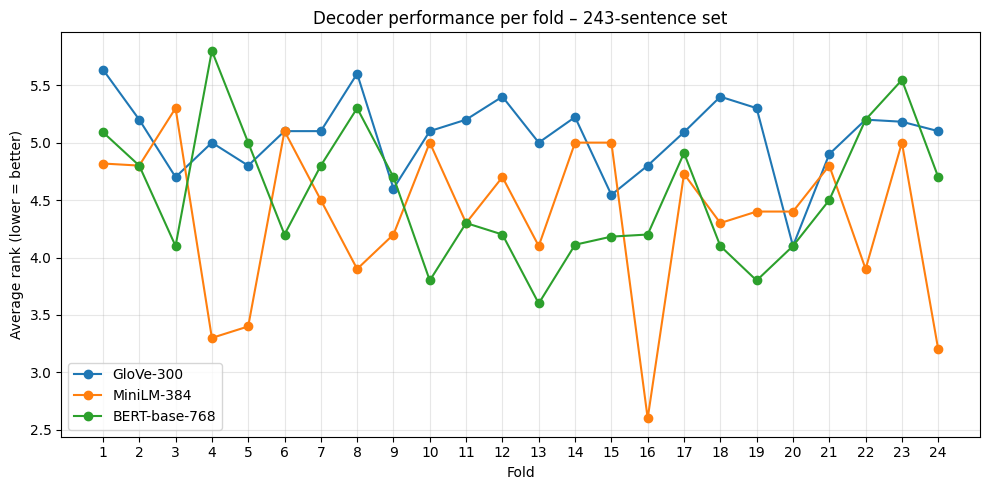

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# one x-value per fold
folds = np.arange(1, len(avg_ranks_243) + 1)

plt.figure(figsize=(10, 5))

plt.plot(folds, avg_ranks_243,   "-o", label="GloVe-300")
plt.plot(folds, avg_minilm_243,  "-o", label="MiniLM-384")
plt.plot(folds, avg_bert_243,    "-o", label="BERT-base-768")

plt.xlabel("Fold")
plt.ylabel("Average rank (lower = better)")
plt.title("Decoder performance per fold – 243-sentence set")
plt.xticks(folds)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()